<a href="https://colab.research.google.com/github/chrisgozali/GA_Projects/blob/main/The_Pawsome_Classifier_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Pawsome Classifier
## Executive Summary

### Background information
#### History of dog pedigrees
"Man's best friend" - a commonly used phrase to describe dogs. Over centuries, dogs have faithfully served as companions to humans by providing assistance to a wide range of activities including hunting, guarding, herding, sport and war. Over the course of history, dogs have been selectively bred based on useful characteristics to optimize their functionality. Therefore, modern day dog pedigrees are a product of such selective breeding, and indirectly reflect the nature of their relationship with humans in the past. Recently, ["designer dogs"](https://www.thesprucepets.com/what-is-a-designer-dog-breed-1118093), where pure-bred dogs are intentionally cross bred to produce offspring with a mixed characteristics of their parents, are becoming a trend.

#### Kennel Clubs
Kennel clubs are organizations that operate nationally to to keep track of dog pedigrees. Additionally, they organize dog shows and competitions. The various kennel clubs also categorize each breed into breed groups based on their general functionality and appearance. It is important to note that each kennel club differs in the methodology used for categorizing dog breeds.

### Problem statement
As an aspiring data scientist new to computer vision, I have planned this project out of personal motivations. Combining my own interest in dogs and machine-learning, I aim to build a model that can categorize dogs by breed. To train the model, I used the Stanford Dogs dataset contains over 20,000 images of 120 different dog breeds. For model evaluation, I included a separate dataset from kaggle with 55 different dog breeds.

#### Summary of Datasets
| Dataset | Source | Purpose | Size | Classes |
|--|--|--|--|--|
| Stanford Dogs | Kaggle |Training|20,580|120|
|55 Dogs| Kaggle | Evaluation|550|55|
|Designer Dogs|Internet|Prediction|20|10|


#### Modelling approach
The modelling process is split in two stages:
1) Firstly, to reduce the dimensionality of the problem without reducing the amount of images used to train the model, I reclassified the 120 breeds into 12 groupings based on [The Continental Kennel Club's](https://ckcusa.com/) (CKC) breed standards. I selected the CKC's groupings for this project as there is a sufficiently diverse classification system of 12 groups which are based highly on the dog's physical appearance. This should be helpful in training the machine learning model to recognize distinct physical features of various dog breeds.


2) The second stage is to use the above model as a base to train the model to recognize 120 different breeds.

#### Results and evaluation
I used transfer-learning with EfficientNet-B7 as a feature extractor to construct my model. To evaluate the performance of the model, I used a separate dataset containing images of 55 different dog breeds. Additionally, I included some "designer dogs" as a stretch goal to see if the model can accurately predict the dog's heritage. As these "designer dogs" are not recognized as "pure breeds", they are not held by Kennel Club breed standards. It could be interesting to see how the model categorizes such "designer dogs". After fine tuning, the models produced the following results:

| Model | Train Acc |Val Acc|
|--|--|--|
| Dog Group Classifier | 92.0% |82.8%|
|Dog Breed Classifier|80.0%|84.0%|

**Baseline Accuracy for Dog Groups**: 10.26%

**Accuracy on unseen data**: 92.0%

This notebook contains the modelling portion of the project

# Import Libraries

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import xml.etree.ElementTree as ET
import numpy as np
import random as random
import cv2
import glob
import itertools
%tensorflow_version 2.3
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.3`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
tf.__version__

'2.5.0'

In [4]:
#Checking GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3600199455130024403
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18025834331490543717
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Load Data

In [5]:
filepath = '/content/drive/MyDrive/project_capstone/data/stanford_dogs/images/Images/'
annotation = '/content/drive/MyDrive/project_capstone/data/stanford_dogs/annotations/Annotation/'
folders = os.listdir(filepath)
annotations = os.listdir(annotation)
breeds=[re.sub('n\d+-','',breed).replace('-','_').lower() for breed in folders]

In [6]:
#Create dictionary containing continental kennel club groupings
dog_families = {'terrier':['bedlington_terrier','border_terrier','kerry_blue_terrier','irish_terrier',
                          'norfolk_terrier','norwich_terrier','yorkshire_terrier','wire_haired_fox_terrier',
                          'lakeland_terrier','sealyham_terrier','airedale','cairn','australian_terrier',
                          'dandie_dinmont','scotch_terrier','tibetan_terrier','silky_terrier',
                          'soft_coated_wheaten_terrier','west_highland_white_terrier'],
                'pinscher_schnauzer':['miniature_schnauzer','giant_schnauzer','standard_schnauzer','doberman',
                                      'miniature_pinscher','affenpinscher','brabancon_griffon'],
                'companion_toy': ['chihuahua','japanese_spaniel','maltese_dog','pekinese','shih_tzu',
                                  'blenheim_spaniel','papillon','toy_terrier','lhasa','pug','toy_poodle',
                                  'miniature_poodle'],
                'sighthound':['afghan_hound','borzoi','irish_wolfhound','italian_greyhound','whippet',
                             'ibizan_hound','saluki','scottish_deerhound'],
                'scenthound':['rhodesian_ridgeback','basset','beagle','bloodhound','bluetick','black_and_tan_coonhound',
                             'walker_hound','english_foxhound','redbone','otterhound'],
               'gundog':['weimaraner','flat_coated_retriever','curly_coated_retriever','golden_retriever',
                         'labrador_retriever','chesapeake_bay_retriever','german_short_haired_pointer',
                         'vizsla', 'english_setter','irish_setter','gordon_setter','brittany_spaniel',
                         'clumber', 'english_springer','welsh_springer_spaniel','cocker_spaniel',
                         'sussex_spaniel', 'irish_water_spaniel','standard_poodle'],
                'primal':['basenji','mexican_hairless','dingo','dhole','african_hunting_dog'],
                'spitz_nordic': ['norwegian_elkhound','eskimo_dog','siberian_husky','malamute','samoyed',
                                'pomeranian','chow','keeshond'],
                'pastoral_stock':['schipperke','groenendael','malinois','briard','kelpie','old_english_sheepdog',
                                  'shetland_sheepdog','collie','border_collie','bouvier_des_flandres','german_shepherd',
                                  'pembroke','cardigan','komondor'],
                'guardian_pastoral_mountain':['kuvasz','greater_swiss_mountain_dog','bernese_mountain_dog','appenzeller',
                                              'entlebucher','tibetan_mastiff','saint_bernard','leonberg','newfoundland',
                                              'great_pyrenees'],
                'mastiff':['rottweiler','boxer','bull_mastiff','great_dane'],
                'bull':['staffordshire_bullterrier','american_staffordshire_terrier','boston_bull','french_bulldog'],
                }

In [7]:
family_filepath = '/content/drive/MyDrive/project_capstone/data/stanford_dogs/cropped_images/dog_families/'
family_folders = os.listdir(family_filepath)

In [8]:
unseen_filepath = '/content/drive/MyDrive/project_capstone/data/55_dogs/'
unseen_folders = os.listdir(unseen_filepath)

# Image Augmentation

In [9]:
batch = 128

In [10]:
train_augment = ImageDataGenerator(rotation_range=40,  
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   horizontal_flip=True,  
                                   vertical_flip=False,
                                   validation_split = 0.2, 
                                   )

#Create imagedatagenerator for validation set
valid_augment = ImageDataGenerator(validation_split = 0.2)

#Create imagedatagenerator for unseen data
unseen_generator = ImageDataGenerator()

In [11]:
train_dataset = train_augment.flow_from_directory(family_filepath,
                                                   target_size = (224,224),
                                                   batch_size = batch,
                                                   subset = 'training',
                                                   seed = 25
                                                   )
valid_dataset = valid_augment.flow_from_directory(family_filepath,
                                                  target_size = (224,224),
                                                  batch_size = batch,
                                                  subset = 'validation',
                                                  seed = 25,
                                                  shuffle = False)


Found 17704 images belonging to 12 classes.
Found 4422 images belonging to 12 classes.


# Callbacks

#### Reducing overfitting
A number of steps were taken to reduce overfitting on the training data including:

1. Reduce learning rate when validation loss does not improve for finer adjustments to weights.
2. Early stopping when validation loss does not improve beyond a set threshold
3. Dropout: Used to randomly drop nodes in a layer during iterations, to reduce the reliance of the model on the same nodes.
4. Image augmentation: Random rotations, flips and shifts to introduce more variance in the training data. (Implemented when loading the data)
5. L2 (ridge) regularization: Regularization on the weights of the trainable layers used to penalize large weights. (Implemented in the dense layer of the model)

Additionally, model checkpoint is included to save the best weights for each model based on validation accuracy.

In [12]:
#Instantiate callbacks
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=5,
                          verbose=1,
                          mode='auto'
)

reduceadam = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 1/np.sqrt(10),
                          patience = 2,
                          cooldown =2,
                          verbose = 1,
                          min_delta = 0.01,
                          min_lr = 0.00001)


#Adjust learning rate reduction for fine tuning
fine_reduce = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 1/np.sqrt(10),
                          patience = 2,
                          cooldown =2,
                          verbose = 1,
                          min_lr = 0.0000001)

#Adjust early stopping condition for model retraining
early_stop_retrain = EarlyStopping(monitor='accuracy',
                          min_delta=0.0001,
                          patience=3,
                          verbose=1,
                          mode='auto')
retrain_reduce = ReduceLROnPlateau(monitor = 'accuracy',
                          factor = 1/np.sqrt(10),
                          patience = 2,
                          cooldown =2,
                          verbose = 1,
                          min_lr = 0.0000001)

#Checkpoints
checkpoint = ModelCheckpoint('/content/drive/MyDrive/project_capstone/models/EfficientNetB7_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')
fine_checkpoint = ModelCheckpoint('/content/drive/MyDrive/project_capstone/models/fine_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')
breed_checkpoint = ModelCheckpoint('/content/drive/MyDrive/project_capstone/models/breed_classifier.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')
retrain_checkpoint = ModelCheckpoint('/content/drive/MyDrive/project_capstone/models/breed_classifier_retrain.h5', 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')


In [13]:
callbacks = [earlystop, reduceadam, checkpoint]
fine_callbacks = [fine_reduce, fine_checkpoint]
breed_callbacks = [earlystop, reduceadam, breed_checkpoint]
retrain_callbacks = [early_stop_retrain, retrain_reduce, retrain_checkpoint]

# Modeling

## Part 1: Continental Kennel Club Dog Groups Classification

### EfficientNetB7 Base Model

The architecture for EfficientNetB7 includes a stem, followed by a series of 7 blocks containing a combination of different sub-blocks. The layers in the model include: Rescaling, normalization, batch normalization, zero padding, convolutional-2D and global average pooling.

The model is pre-trained on weights from the imagenet competition and therefore has been optimized for image classifcation on that dataset. By removing the top layers of the model, we remove the prediction layers and adapt the model to this specific classification problem. Doing this allows us to use EfficientNetB7 feature extractor for transfer learning. 

For transfer learning, it is important to freeze the layers of the base model so that the weights do not update during the training process.

In [14]:
#Instantiate base model
base_model = EfficientNetB7(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

#Freeze weights in convolutional base model
base_model.trainable = False

258080768/258076736 [==============================] - 2s 0us/step


In [15]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# Add custom top layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1280, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(12,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              3278080   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                15372     
Total params: 67,391,139
Trainable params: 3,293,452
Non-trainable params: 64,097,687
_________________________________________________________________


In [17]:
#set initial learning rate
opt = Adam(learning_rate = 0.0003)

In [18]:
#compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['accuracy'])

In [19]:
#Fit model
history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = valid_dataset,
                    verbose = 1,
                    callbacks=callbacks,
                    batch_size = batch)

Epoch 1/20
139/139 [==============================] - 7052s 51s/step - loss: 7.3498 - accuracy: 0.8475 - val_loss: 2.1912 - val_accuracy: 0.8012

Epoch 00001: val_accuracy improved from -inf to 0.80122, saving model to /content/drive/MyDrive/project_capstone/models/EfficientNetB7_model.h5
Epoch 2/20
139/139 [==============================] - 340s 2s/step - loss: 0.9882 - accuracy: 0.8923 - val_loss: 1.0861 - val_accuracy: 0.7847

Epoch 00002: val_accuracy did not improve from 0.80122
Epoch 3/20
139/139 [==============================] - 321s 2s/step - loss: 0.6092 - accuracy: 0.8915 - val_loss: 0.9287 - val_accuracy: 0.8198

Epoch 00003: val_accuracy improved from 0.80122 to 0.81976, saving model to /content/drive/MyDrive/project_capstone/models/EfficientNetB7_model.h5
Epoch 4/20
139/139 [==============================] - 320s 2s/step - loss: 0.5837 - accuracy: 0.8940 - val_loss: 0.9179 - val_accuracy: 0.8089

Epoch 00004: val_accuracy did not improve from 0.81976
Epoch 5/20
139/139 [=

#### Model Evaluation

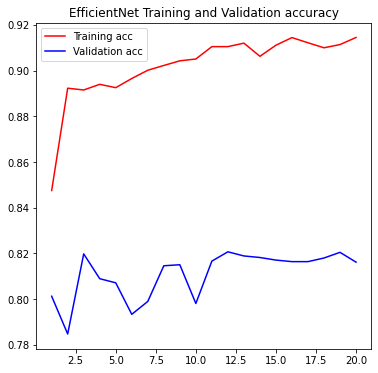

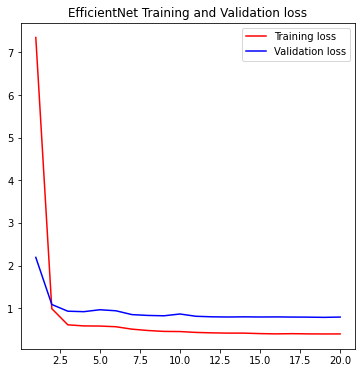

In [20]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('EfficientNet Training and Validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('EfficientNet Training and Validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [21]:
#Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
#make predictions
preds = model.predict(valid_dataset)
preds = preds.argmax(axis=-1)

preds.shape

(4422,)

In [23]:
#Get true labels from datagenerator
true_label = []
for i in range( valid_dataset.__len__() ):
    true_label.extend(
        valid_dataset.__getitem__( i )[1].argmax(axis = -1) 
        )

In [24]:
#Get class labels
class_labels = list(valid_dataset.class_indices.keys())

In [25]:
#Create confusion matrix
cm = confusion_matrix(y_true = true_label,
                      y_pred = preds)

Normalized confusion matrix


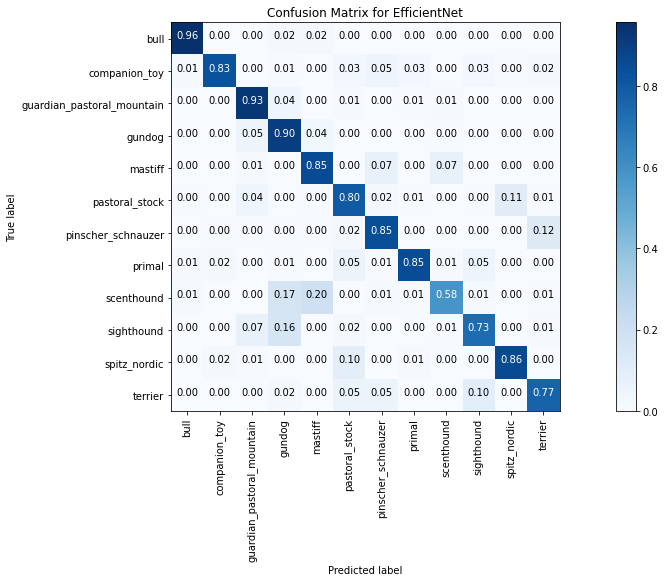

In [26]:
# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, class_labels, normalize=True,
                      title='Confusion Matrix for EfficientNet')

plt.show()

#### Preliminary analysis
**Validation accuracy: 82.7%**

**Top accuracies (90% and above)**:
The following classes showed the most accurately predicted images for the model. Distinct features for these classes helped with differentiating them from other classes.
- bull (96% accuracy): Unique head shape (flat faced)
- guardian_pastoral_mountain (92% accuracy) : Large dogs with stocky build
- gundog (90% accuracy): Medium sized dogs with droopy ears


#### Misclassification Analysis

**Lowest accuracy**:

- Scenthound (58% accuracy): 
  - 15% were misclassified as gundogs and 22% as mastiffs. Scenhounds tend to have a larger snout and droopy ears. These features can be easily confused with gundogs, which have droopy ears, and mastiffs, which had broader faces.

- Sighthound (77% accuracy):
  - 13% were misclassified as gundogs. Sighthounds tend to be not only lean bodied but also lean faced. This feature could be confused with some breeds of gun dogs which also have longer faces.



### Fine Tuning

Fine tuning can be performed by unfreezing some, or all layers in the base model, then continue training the previous model using a reduced learning rate. Since the EfficientNet model has performed quite well using weights from imagenet, I will be keeping most of the layers in the base model frozen. With the exception of batch normalization layers, only layers in block 7 will be unfrozen for retraining.

In [27]:
#Unfreeze the layers in base_model
base_model.trainable = True

In [28]:
#Check total number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  813


In [29]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [30]:
# Fine-tune from this layer onwards
fine_tune_at = 752

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [31]:
base_model.layers[811]

In [32]:
#Freeze BatchNormalization layers
for layer in base_model.layers:
  if layer.trainable == True and type(layer) == type(base_model.layers[811]):
    layer.trainable = False

In [33]:
#Reduce learning rate to reduce overfitting
fine_opt = Adam(learning_rate = 0.000001)
fine_model = model
fine_model.compile(loss = 'categorical_crossentropy',
                   optimizer = fine_opt,
                   metrics = ['accuracy'])

In [34]:
fine_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              3278080   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                15372     
Total params: 67,391,139
Trainable params: 26,304,332
Non-trainable params: 41,086,807
_________________________________________________________________


In [35]:
#Number of trainable layers
len(fine_model.trainable_variables)

33

In [36]:
fine_tune_epochs = 10
initial_epochs = history.epoch[-1]
total_epochs = initial_epochs + fine_tune_epochs

In [37]:
fine_history = fine_model.fit(train_dataset,
                              epochs = total_epochs,
                              initial_epoch = initial_epochs,
                              validation_data = valid_dataset,
                              verbose = 1,
                              callbacks = fine_callbacks)

Epoch 20/29
139/139 [==============================] - 353s 2s/step - loss: 0.3886 - accuracy: 0.9145 - val_loss: 0.7783 - val_accuracy: 0.8186

Epoch 00020: val_accuracy improved from -inf to 0.81863, saving model to /content/drive/MyDrive/project_capstone/models/fine_model.h5
Epoch 21/29
139/139 [==============================] - 330s 2s/step - loss: 0.3889 - accuracy: 0.9140 - val_loss: 0.7718 - val_accuracy: 0.8164

Epoch 00021: val_accuracy did not improve from 0.81863
Epoch 22/29
139/139 [==============================] - 330s 2s/step - loss: 0.3809 - accuracy: 0.9153 - val_loss: 0.7656 - val_accuracy: 0.8164

Epoch 00022: val_accuracy did not improve from 0.81863
Epoch 23/29
139/139 [==============================] - 329s 2s/step - loss: 0.3722 - accuracy: 0.9162 - val_loss: 0.7591 - val_accuracy: 0.8177

Epoch 00023: val_accuracy did not improve from 0.81863
Epoch 24/29
139/139 [==============================] - 330s 2s/step - loss: 0.3728 - accuracy: 0.9148 - val_loss: 0.7503 

#### Fine Tuned Model Evaluation

In [38]:
acc += fine_history.history['accuracy']
val_acc += fine_history.history['val_accuracy']

loss += fine_history.history['loss']
val_loss += fine_history.history['val_loss']

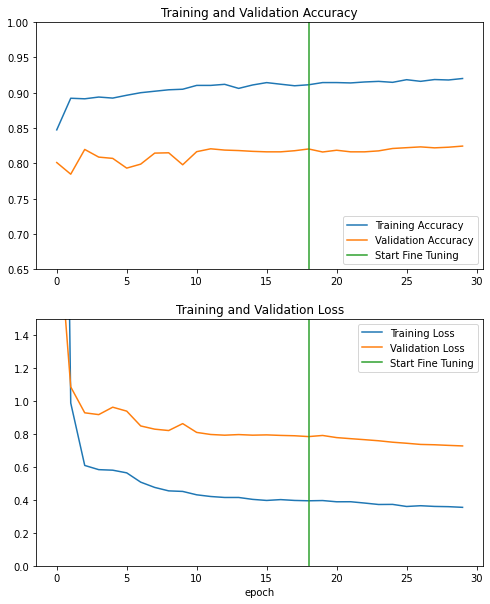

In [39]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.65, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
#load best weights
fine_model.load_weights('/content/drive/MyDrive/project_capstone/models/fine_model.h5')

In [41]:
#make predictions
fine_preds = fine_model.predict(valid_dataset)
fine_preds = fine_preds.argmax(axis=-1)

fine_preds.shape

(4422,)

In [42]:
true_label = []
for i in range( valid_dataset.__len__() ):
    true_label.extend(
        valid_dataset.__getitem__( i )[1].argmax(axis = -1) 
        )

In [43]:
fine_cm = confusion_matrix(y_true = true_label,
                      y_pred = fine_preds)

Normalized confusion matrix


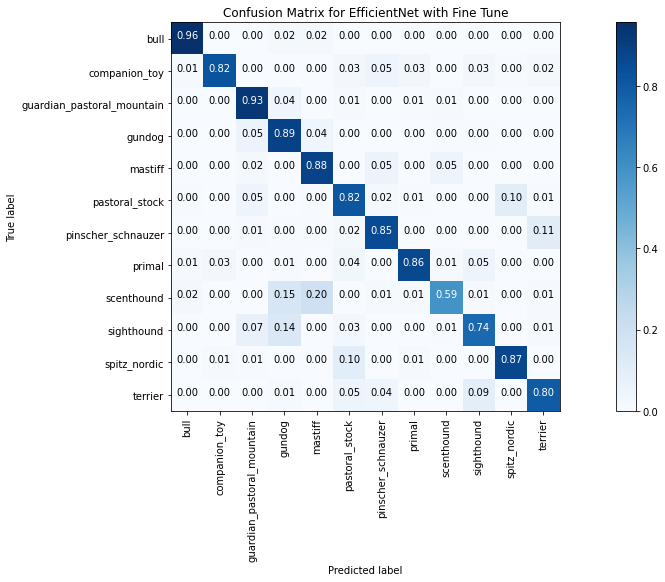

In [44]:
# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(fine_cm, class_labels, normalize=True,
                      title='Confusion Matrix for EfficientNet with Fine Tune')

plt.show()

**Validation accuracy: 82.8%**

#### Misclassification Analysis

Performance after fine tuning is similar to without fine tuning. Misclassifications remain similar as mentioned in the preliminary analysis. This suggests an inherent issue with the data itself which makes it difficult to differentiate between certain dog species.

Similar to the preliminary analysis, the lowest accuracy belonged to the scenthounds class, which share similar features as gundogs and mastiffs.


#### Results Analysis

In [45]:
# Function to select random misclassifications and show the misclassified image
def misclass_checker(generator, batchsize, truelabel, predlabel, classlabels):
  misclass = []
  misclass_index = []
  for i in range(len(predlabel)):
    if predlabel[i] != truelabel[i]:
      misclass.append((predlabel[i],truelabel[i]))
      misclass_index.append(i)
  #preview some misclassified images:
  preview = random.randint(0,len(misclass)-1)
  id = misclass_index[preview]
  misclass_labels = misclass[preview]

  batch_no = id//batchsize
  image_no = id - (batch_no * batchsize)

  pred_label = classlabels[misclass_labels[0]]
  true_label = classlabels[misclass_labels[1]]

  print(f'Predicted: {pred_label}\n Actual: {true_label}')

  return plt.imshow(generator[batch_no][0][image_no]/255);

Predicted: mastiff
 Actual: scenthound


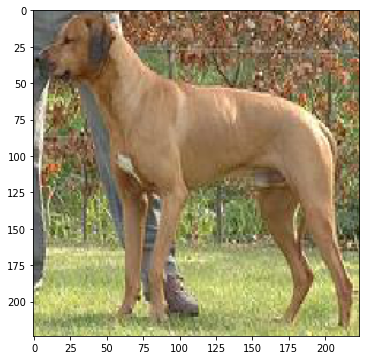

In [46]:
misclass_checker(generator = valid_dataset,
                 batchsize = batch,
                 truelabel = true_label,
                 predlabel = fine_preds,
                 classlabels = class_labels);

## Dog breeds classificiation

In [47]:
train_dataset2 = train_augment.flow_from_directory(filepath,
                                                   target_size = (224,224),
                                                   batch_size = batch,
                                                   subset = 'training',
                                                   seed = 25
                                                   )
valid_dataset2 = valid_augment.flow_from_directory(filepath,
                                                    target_size = (224,224),
                                                    batch_size = batch,
                                                    subset = 'validation',
                                                    seed = 25,
                                                   shuffle = False)
unseen_dataset = unseen_generator.flow_from_directory(unseen_filepath,
                                                      target_size = (224,224),
                                                      batch_size = 55,
                                                      seed = 25,
                                                      shuffle = False)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Found 550 images belonging to 55 classes.


In [48]:
breed_classifier = fine_model

In [49]:
#Load best weights from model fine tuning
breed_classifier.load_weights('/content/drive/MyDrive/project_capstone/models/fine_model.h5')

In [50]:
#Freeze the fine-tuned EfficientNet model
breed_classifier.layers[0].trainable = False

In [51]:
#Remove prediction layer and add new prediction layer for 120 breeds
breed_classifier.pop()
breed_classifier.add(Dense(120, activation = 'softmax'))
breed_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              3278080   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               153720    
Total params: 67,529,487
Trainable params: 3,431,800
Non-trainable params: 64,097,687
_________________________________________________________________


In [52]:
opt = Adam(learning_rate = 3e-4)
breed_classifier.compile(loss='categorical_crossentropy',
                         optimizer= opt,
                         metrics=['accuracy'])

In [ ]:
# # Train the model with validation 
breed_history = breed_classifier.fit(train_dataset2,
                                     epochs = 30,
                                     validation_data = valid_dataset2,
                                     verbose = 1,
                                     callbacks=breed_callbacks,
                                     batch_size = batch)

Epoch 1/30
 38/129 [=======>......................] - ETA: 1:02:15 - loss: 3.1699 - accuracy: 0.4996

### Model Evaluation


In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

breed_acc = breed_history.history['accuracy']
breed_val_acc = breed_history.history['val_accuracy']
breed_loss = breed_history.history['loss']
breed_val_loss = breed_history.history['val_loss']
breed_epochs = range(1, len(breed_acc) + 1)

plt.title('Breed Classifier: Training and Validation accuracy')
plt.plot(breed_epochs, breed_acc, 'red', label='Training acc')
plt.plot(breed_epochs, breed_val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Breed Classifier: Training and Validation loss')
plt.plot(breed_epochs, breed_loss, 'red', label='Training loss')
plt.plot(breed_epochs, breed_val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

We note that the training accuracy is higher than the validation accuracy. This could be due to 1 of 2 reasons:
1. Validation data was not subject to image augmentation and therefore is easier to predict than train data
2. Model had been tuned well prior to this fitting.

In [ ]:
true_breed = []
for i in range( valid_dataset2.__len__() ):
    true_breed.extend(
        valid_dataset2.__getitem__( i )[1].argmax(axis = -1) 
        )

In [ ]:
#Load best weights for prediction
breed_classifier.load_weights('/content/drive/MyDrive/project_capstone/models/breed_classifier.h5')

In [ ]:
val_breed_preds = breed_classifier.predict(valid_dataset2)
val_breed_preds = val_breed_preds.argmax(axis=-1)

val_breed_preds.shape

In [ ]:
breed_cm = confusion_matrix(y_true = true_breed,
                      y_pred = val_breed_preds)

In [ ]:
breed_labels = list(valid_dataset2.class_indices.keys())

In [ ]:
# # Plot normalized confusion matrix
plt.figure(figsize=(64,32))
plot_confusion_matrix(breed_cm, breed_labels, normalize=True,
                      title='Confusion Matrix for Breed Classifier')

plt.show()

In [ ]:
misclass_checker(generator = valid_dataset2,
                 batchsize = batch,
                 truelabel = true_breed,
                 predlabel = val_breed_preds,
                 classlabels = breed_labels);

#### Retrain on full dataset

Before evaluating the model's performance on new data, we first retrain the model using the entire training dataset.

In [ ]:
retrain_augment = ImageDataGenerator(rotation_range=40,  
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   horizontal_flip=True,  
                                   vertical_flip=False, 
                                   )

In [ ]:
retrain_dataset = retrain_augment.flow_from_directory(filepath,
                                                      target_size = (224,224),
                                                      batch_size = batch,
                                                      seed = 25
                                                      )

In [ ]:
retrain_history = breed_classifier.fit(retrain_dataset,
                                     epochs = 20,
                                     verbose = 1,
                                     callbacks=retrain_callbacks,
                                     batch_size = batch)

#### Predictions on unseen data

The unseen dataset contains 10 images each of 55 different dog breeds included in the training dataset.

In [ ]:
#load best weights
breed_classifier.load_weights('/content/drive/MyDrive/project_capstone/models/breed_classifier_retrain.h5')

In [ ]:
#make predictions on unseen data
breed_preds = breed_classifier.predict(unseen_dataset)
breed_preds = breed_preds.argmax(axis=-1)

breed_preds.shape

In [ ]:
#ensure that folder names are sorted in alphabetical order 
#to match the encoded labels generated using the imagedatagenerator
unseen_folders.sort()

In [ ]:
#Get predictions for unseen data as breed names
unseen_preds = []
for i in breed_preds:
  unseen_preds.append(breed_labels[i])

In [ ]:
#Get encoded true labels
unseen_num = []
for i in range( unseen_dataset.__len__() ):
  unseen_num.extend(
        unseen_dataset.__getitem__( i )[1].argmax(axis = -1) 
        )

In [ ]:
#Match encoded labels with the breed
unseen_true = []
for i in unseen_num:
  unseen_true.append(unseen_folders[i])

In [ ]:
#Check shape
print(len(unseen_preds))
print(len(unseen_true))

In [ ]:
#Filter out misclassifications
misclass = []
for i in range(len(unseen_true)):
  if unseen_preds[i] != unseen_true[i]:
    misclass.append((unseen_preds[i],unseen_true[i]))

In [ ]:
print(f'Total misclassifications: {len(misclass)}')
unseen_accuracy = 1 - (len(misclass)/len(unseen_true))
print(f'Accuracy for unseen data is : {100*round(unseen_accuracy,3)} %')


The model performs really well for new data! With an accuracy of 91.8%

Let's take a closer look at why these misclassifications occured.

In [ ]:
# Print misclassifications for classes that do not exist in the unseen dataset
for i in range(len(misclass)):
  if misclass[i][0] not in unseen_folders:
    print(f'Predicted Label: {misclass[i][0]} \nTrue Label: {misclass[i][1]}\n')

As shown above, a large number of misclassifications are a result of the model predicting labels that are not included in the unseen dataset.
miniature schnauzer <-> standard schnauzer <-> giant schnauzer
miniature poodle <-> standard poodle <-> toy poodle

Although the model could not predict the exact breed of these dogs, it was able to predict different size variations of similar breeds.

In [ ]:
# Print misclassifications for classes that exist in unseen dataset
for i in range(len(misclass)):
  if misclass[i][0] in unseen_folders:
    print(f'Predicted Label: {misclass[i][0]} \nTrue Label: {misclass[i][1]}\n')

### Designer Dog Predictions

As the model seems to be performing well, let's explore whether it is able to accurately predict the parentage of designer dogs.

In [ ]:
#Upload crossbreeds
designer_filepath = '/content/drive/MyDrive/project_capstone/data/designer_dogs/'
designer_dogs = os.listdir(designer_filepath)

In [ ]:
designer_dataset = unseen_generator.flow_from_directory(designer_filepath,
                                                      target_size = (224,224),
                                                      shuffle = False)

In [ ]:
designer_preds = breed_classifier.predict(designer_dataset)

In [ ]:
len(designer_preds[0])

In [ ]:
designer_preds.shape

In [ ]:
designer_preds_df = pd.DataFrame(data = designer_preds, columns = breed_labels)
designer_preds_df

In [ ]:
print(f'Chorkie = Chihuahua + Yorkshire Terrier (Yorkie)\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[0].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][0]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][1]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[1].nlargest(3)}')

In [ ]:
# Chug = Chihuahua + pug
print(f'Chug = Chihuahua + Pug\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[2].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][2]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][3]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[3].nlargest(3)}')

In [ ]:
print(f'Cockapoo = Cocker spaniel + Poodle\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[4].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][4]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][5]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[5].nlargest(3)}')

In [ ]:
print(f'Goldendoodle = Golden Retriever + Poodle\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[6].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][6]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][7]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[7].nlargest(3)}')

In [ ]:
print(f'Labradoodle = Labrador Retriever + Poodle')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[8].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][8]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][9]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[9].nlargest(3)}')

In [ ]:
print(f'Morkie = Maltese + Yorkshire Terrier (Yorkie)\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[10].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][10]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][11]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[11].nlargest(3)}')

In [ ]:
print(f'Pomsky = Pomeranian + Siberian Husky\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[12].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][12]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][13]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[13].nlargest(3)}')

In [ ]:
print(f'Puggle = Pug + Poodle\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[14].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][14]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][15]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[15].nlargest(3)}')

In [ ]:
print(f'Schnoodle = Schnauzer + Poodle\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[16].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][16]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][17]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[17].nlargest(3)}')

In [ ]:
print(f'Shihpoo = Shih Tzu + Poodle\n')
plt.figure(figsize = (8,12))
print(f'Predicted probabilities for first image: \n{designer_preds_df.iloc[18].nlargest(3)}\n')
ax = plt.subplot(2,1,1)
plt.imshow(designer_dataset[0][0][18]/255);
ax = plt.subplot(2,1,2)
plt.imshow(designer_dataset[0][0][19]/255);
print(f'Predicted probabilities for second image: \n{designer_preds_df.iloc[19].nlargest(3)}')

# Conclusions

### Results Summary


| Model | Train Acc |Val Acc|
|--|--|--|
| Dog Group Classifier | 90.0% |82.0%|
|Dog Breed Classifier|80.0%|84.0%|


- Baseline Accuracy for Dog Groups: **10.26%**
- Breed Classifier Accuracy on unseen data: **92.0%**

- Both the dog group classifier and dog breed classifier performed well
- Performance of dog breed classifier on *designer dogs* is quite limited but able to predict **at least 1 parent**

### Potential Use cases

 1. Kennel Clubs can use the Group Classifier when people want to register dogs to help classify the breed into its correct grouping, streamlining the registration process.
 2. Kennel Clubs can use the Breed Classifier to assess how close of a match a specific dog is to their ideal standard. This can be an interesting use case in dog competitions/shows
 3. The Breed Classifier can also be used to identify possible parentage or origins of a dog of unknown breed or mixed breed. 

### Future Work

 1. Include model for object detection
  - Object detection can be used to deploy the model on live cameras. This helps to focus the classification model to an area of interest where the dog is in focus.
 2. Include more than 120 breeds
  - Since the model is able to perform well with 120 breeds, the scope can be expanded to include more dog breeds that exist
 3. Adapt model to classify breeds for a different animal eg. Cats
 4. Adapt model to classify newly discovered species into appropriate grouping
  - Even to this day, scientists are discovering new species of animals. Computer vision can potentially be used as a powerful tool to help in categorizing newly discovered species into appropriate groupings.